# Benchmarking of 'in-loop' RTC

We measure the performance of the RTC whilst it is inside the simulation loop. The timing is done without including the iterator over the controllers. We can do this by utilising the built in supervisor but modifying a few of the simulator's functions such that a timer is started before and after it runs.

## Notebook to script

Execute the following to convert it to a script (change it to a code cell first!)

```bash
!jupyter nbconvert --to script benchmarking-rtc-loop.ipynb
```

However, the script will only run properly when in the ```$SHESHA_ROOT``` folder as a working directory.

## Imports

In [41]:
import os
import matplotlib.pyplot as plt
from shesha.util.sys_util import wait_for_idle

## Constants

We set the constants beforehand

**DEVICES:** The GPU devices being used

**THRESHOLD:** The simulator will wait for idle before running, set what 'idle' is by utilisation % in THRESHOLD_CPU and THRESHOLD_GPU

**NITER:** Number of iterations

**PARAM_FILE:** Path to the parameter file used

In [42]:
def is_jupyter():
    """Check if running in jupyter"""
    try:
        if str(get_ipython()).find("ipykernel") == 1:
            return True
        return False
    except Exception:
        return False
IS_JUPYTER = is_jupyter()

DEVICES = [0]
THRESHOLD_CPU, THRESHOLD_GPU = (30, 5)
NITER = 10000
PARAM_FILE = os.path.abspath("../data/par/par4bench/scao_sh_16x16_8pix.py")
RUNTIME_IMAGE = None
PROFILE_IMAGE = None

if not IS_JUPYTER:
    from argparse import ArgumentParser
    
    parser = ArgumentParser()
    parser.add_argument("file", help="Parameter .py file", type=str)
    parser.add_argument("-r", "--runtime_image", default=os.path.abspath("./runtime.png"), help="Save runtime plot as an image")
    parser.add_argument("-p", "--profile_image", default=os.path.abspath("./profile.png"), help="Save execution profile graph as an image")
    parser.add_argument("--devices", default=DEVICES, nargs='+', help='A list of GPU devices ex. "0 1 2"', type=int)
    parser.add_argument("--threshold_cpu", default=THRESHOLD_CPU, help="Wait for CPU utilisation to drop below specified amount in percent", type=float)
    parser.add_argument("--threshold_gpu", default=THRESHOLD_GPU, help="Wait for GPU utilisation to drop below specified amount in percent", type=float)
    parser.add_argument("-n", "--niter", default=NITER, help="Number of iterations to benchmark over", type=int)

    args = parser.parse_args()

    DEVICES = args.devices
    THRESHOLD_CPU, THRESHOLD_GPU = (args.threshold_cpu, args.threshold_gpu)
    NITER = args.niter
    PARAM_FILE = os.path.abspath(args.file)
    RUNTIME_IMAGE = os.path.abspath(args.runtime_image)
    PROFILE_IMAGE = os.path.abspath(args.profile_image)

## Timer Setup

We setup our timing wrapper using the high precision timer in ```timeit```. This wrapper will add times to a specified array.

In [43]:
from timeit import default_timer as get_time

def timer_wrap_function(times, function):
    """
    Returns the function wrapped in another function. The inner function will be timed, 
    and times will be added to a specified array
    """
    
    def wrapper(*args, **kwargs):        
        start_time = get_time()
        res = function(*args, **kwargs)
        end_time = get_time()
        times.append(end_time - start_time)
        return res
    return wrapper

## Simulation Setup

This section sets up the simulation based on the parameter file given. We will also inject our timing wrappers here.

In [44]:
from shesha.supervisor.compassSupervisor import CompassSupervisor as Supervisor

supervisor = Supervisor(PARAM_FILE)
supervisor.config.p_loop.set_devices(DEVICES)
supervisor.initConfig()
simulator = supervisor._sim

  0%|          | 0/1 [00:00<?, ?it/s]

loading: scao_sh_16x16_8pix
->tel
*-----------------------
Computing geometry of WFS 0
r0 for WFS : 0.16  m
seeing for WFS :  0.64 "
quantum pixsize :  0.0580 "
simulated FoV :  3.71 " x  3.71 "
actual pixsize :  0.2901
actual FoV :  2.32 " x  2.32 "
number of phase points :  18
size of fft support :  64
size of HR spot support :  64
pupdiam used:  288
Generic pupil created
nphotons :  1577393.3612004826
->atmos
Creating turbulent layers :


100%|██████████| 284/284 [00:00<00:00, 3052.22it/s]


->dm
Pattern type : square
Computing Influence Function type :  default


DM1: 100%|██████████| 2/2 [00:00<00:00, 2228.64it/s]

->target
->wfs
->rtc
Doing imat geom...
Filtering unseen actuators... 
Done
CONTROLLER ADDED


done in 0.538899 s
Doing imat svd...
svd done in 0.010949 s
Building cmat...
Filtering  4  modes
cmat done in 0.000328 s


In [45]:
sim_times = []

simulator.doCalibrate_img = timer_wrap_function(sim_times, simulator.doCalibrate_img)
simulator.doCentroids = timer_wrap_function(sim_times, simulator.doCentroids)
simulator.doControl = timer_wrap_function(sim_times, simulator.doControl)
simulator.doClipping = timer_wrap_function(sim_times, simulator.doClipping)
simulator.applyControl = timer_wrap_function(sim_times, simulator.applyControl)

## RTC Loop

We manually loop through each iteration, allowing the simulator to do its thing with the wrapped functions. After each iteration, the times are summed and inserted into another array for data collection.

In [46]:
loop_times = []

wait_for_idle(THRESHOLD_CPU, THRESHOLD_GPU, DEVICES)

for i in range(NITER):
    simulator.next()
    loop_times.append(sum(sim_times))
    sim_times.clear()
    
print("Iterations done.")

Waiting until CPU and GPU idle.... (< 30% CPU < 5% GPU)
CPU at 5.1% and GPU at 0.0%
Wait is over, let's go
Iterations done.


## Plotting the results

We create the data plots to see the distribution of runtimes. This allows us to see if there is jitter within the control loop, and what sort of jitter it is. Additionally we have the execution profile as a histogram, to see the range of execution times and their frequency.

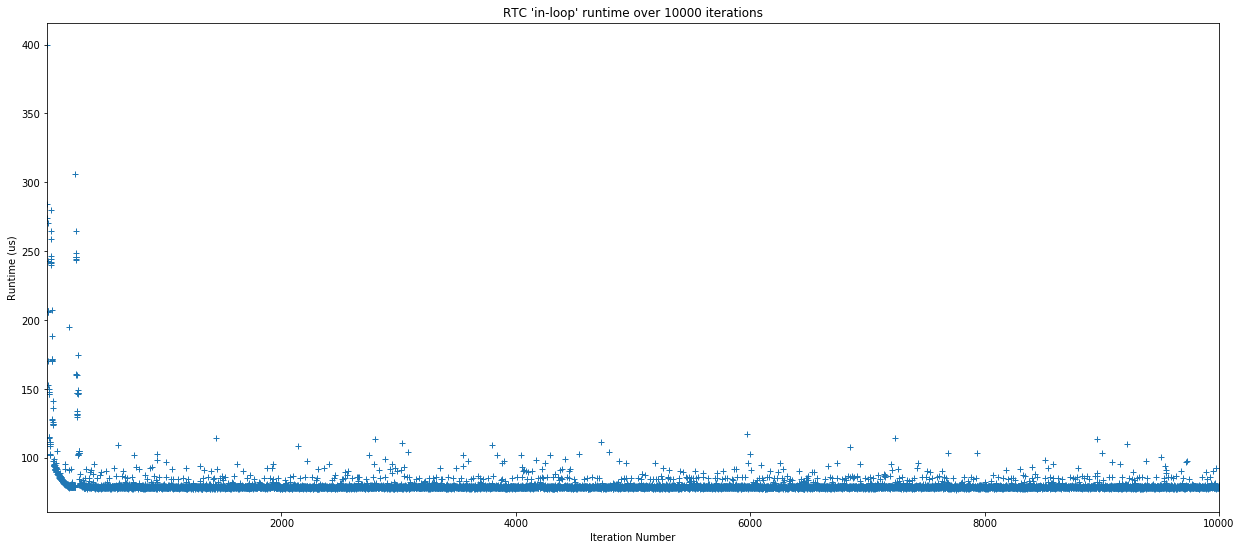

In [47]:
fig = plt.figure(figsize=(21,9))
ax = fig.add_subplot(1, 1, 1)
ax.plot([i for i in range(1, NITER + 1)], [n * 1e6 for n in loop_times], '+')
ax.set_xlim(1, NITER)
# ax.set_ylim(70, 160)
ax.set_title("RTC 'in-loop' runtime over {} iterations".format(NITER))
ax.set_xlabel("Iteration Number")
ax.set_ylabel("Runtime (us)")
fig.show()
if RUNTIME_IMAGE is not None:
    fig.savefig(RUNTIME_IMAGE)

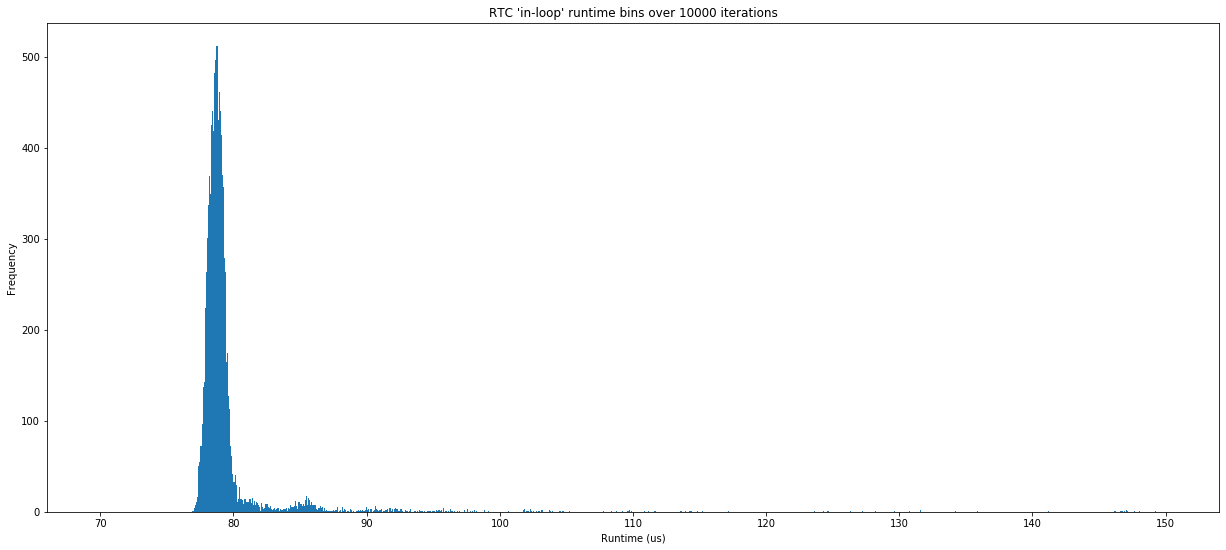

In [48]:
fig = plt.figure(figsize=(21,9))
ax = fig.add_subplot(1, 1, 1)
ax.hist([n * 1e6 for n in loop_times], bins = 1000, range=(70,150))
ax.set_title("RTC 'in-loop' runtime bins over {} iterations".format(NITER))
ax.set_xlabel("Runtime (us)")
ax.set_ylabel("Frequency")
fig.show()
if PROFILE_IMAGE is not None:
    fig.savefig(PROFILE_IMAGE)